# Prepare data

In [8]:
import pandas as pd


DAILY_STOCKS_RETURNS_PATH = ("./../data/stocks_data.xlsx")

df = pd.read_excel(DAILY_STOCKS_RETURNS_PATH, sheet_name="Returns", index_col=2, header=6)
df = df.iloc[:, 3:].T
df.to_pickle('./../data/stocks_data.pkl')

In [27]:
import pandas as pd


df_daily_data = pd.read_excel('./../data/stocks_daily_data.xlsx', index_col=0)
df_daily_data.to_pickle('./../data/stocks_daily_data.pkl')

df_daily_data = df_daily_data[df_daily_data['BP/ LN Equity'].notna()]

train = df_daily_data[:1200]
test = df_daily_data[1200:]

print(train.shape[0], test.shape[0])

1200 399


In [54]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


def preprocess_data(df):
    """
    Preprocesses the data by scaling it to the range [0, 1].

    Parameters:
    df (pd.DataFrame): DataFrame containing the data to be scaled.

    Returns:
    np.ndarray: Scaled data.
    MinMaxScaler: Fitted scaler.
    """
    # Extract closing prices as a 2D array
    data = df.values.reshape(-1, 1)
    # Initialize MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Fit and transform the data
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Function to create sequences for LSTM
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


# Assuming train and test are your DataFrames with columns for each company's closing prices
company_train_data = {company: train[[company]] for company in train.columns}
company_test_data = {company: test[[company]] for company in test.columns}

# Preprocess the data for each company
scaled_train_data = {}
scaled_test_data = {}
scalers = {}

for company in company_train_data:
    # Scale training data
    scaled_train_data[company], scalers[company] = preprocess_data(company_train_data[company])
    # Scale test data using the same scaler
    scaled_test_data[company] = scalers[company].transform(company_test_data[company].values.reshape(-1, 1))

# Verify the scaled data
for company in scaled_train_data:
    print(f"Scaled train data for {company}: {scaled_train_data[company][:5]}")
    print(f"Scaled test data for {company}: {scaled_test_data[company][:5]}")


Scaled train data for BP/ LN Equity: [[0.43729136]
 [0.47276173]
 [0.44691688]
 [0.44323846]
 [0.42048479]]
Scaled test data for BP/ LN Equity: [[0.56375251]
 [0.24487518]
 [0.41306306]
 [0.57325605]
 [0.45581668]]
Scaled train data for STERV FH Equity: [[0.51333561]
 [0.56657316]
 [0.54951356]
 [0.50809842]
 [0.52178815]]
Scaled test data for STERV FH Equity: [[0.6120236 ]
 [0.26511509]
 [0.62710405]
 [0.58604557]
 [0.50409326]]
Scaled train data for IP US Equity: [[0.43457174]
 [0.4000472 ]
 [0.42365931]
 [0.39510546]
 [0.38335958]]
Scaled test data for IP US Equity: [[       nan]
 [0.36799541]
 [0.42170827]
 [0.50077794]
 [0.37044005]]
Scaled train data for FMC US Equity: [[0.56991061]
 [0.635207  ]
 [0.60726823]
 [0.61077131]
 [0.56702154]]
Scaled test data for FMC US Equity: [[       nan]
 [0.48642918]
 [0.57443674]
 [0.61031542]
 [0.59939637]]
Scaled train data for TTE FP Equity: [[0.4763876 ]
 [0.53860752]
 [0.49287126]
 [0.51916651]
 [0.4993189 ]]
Scaled test data for TTE FP Eq

In [2]:
import pandas as pd

from model.score_investment_daily import Preprocessing


predicted_tweets = pd.read_csv('./../data/new_webscrapping_predicted/concatenated_prediction.csv')
stocks_data = pd.read_pickle('./../data/stocks_data.pkl')

ap = Preprocessing()
predicted_tweets_processed, stocks_data_processed = ap.process(predicted_tweets, stocks_data)


/var/folders/9t/_dbsg1912_q5_0l71jrhnvlr0000gn/T/ipykernel_88397/1728020502.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  predicted_tweets = pd.read_csv('./../data/new_webscrapping_predicted/concatenated_prediction.csv')


In [3]:
predicted_tweets_processed

,year,month,day,company,positive_ratio,yearmonthday
0,2011,5,14,TOTALENERGIES SE,0.000000,2011-05-14
1,2011,6,17,TOTALENERGIES SE,0.500000,2011-06-17
2,2011,8,17,TOTALENERGIES SE,0.500000,2011-08-17
3,2011,9,15,TOTALENERGIES SE,0.500000,2011-09-15
4,2011,10,20,TOTALENERGIES SE,0.500000,2011-10-20
...,...,...,...,...,...,...
10642,2024,4,26,TOTALENERGIES SE,0.459350,2024-04-26
10643,2024,4,27,TOTALENERGIES SE,0.435449,2024-04-27
10644,2024,4,28,TOTALENERGIES SE,0.530303,2024-04-28
10645,2024,4,29,TOTALENERGIES SE,0.498282,2024-04-29


In [11]:
aggregated_data = predicted_tweets_processed.groupby(['month', 'year', 'day'])[['sentiment', 'sentiment_base']].mean()

In [12]:
aggregated_data.reset_index(inplace=True)
aggregated_data['date'] = pd.to_datetime(aggregated_data[['year', 'month', 'day']])

<Axes: xlabel='date', ylabel='sentiment'>

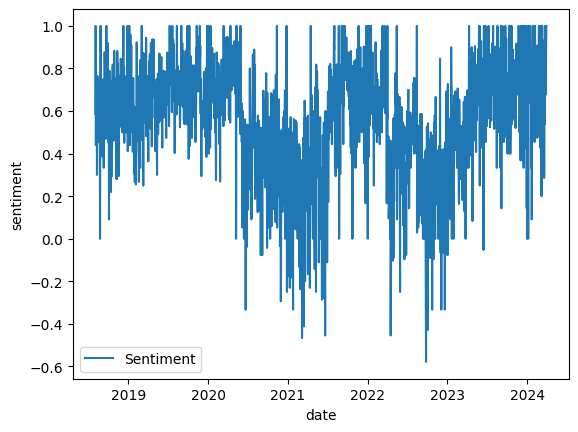

In [13]:
import seaborn as sns


sns.lineplot(data=aggregated_data, x='date', y='sentiment', label='Sentiment')

In [15]:
aggregated_data['moving_sentiment'] = aggregated_data['sentiment'].rolling(window=20).mean()

In [17]:
aggregated_data

,month,year,day,sentiment,sentiment_base,date,moving_sentiment
0,1,2019,1,0.846154,0.076923,2019-01-01,NaN
1,1,2019,2,0.565217,0.043478,2019-01-02,NaN
2,1,2019,3,0.875000,0.000000,2019-01-03,NaN
3,1,2019,4,0.789474,0.210526,2019-01-04,NaN
4,1,2019,5,1.000000,0.000000,2019-01-05,NaN
...,...,...,...,...,...,...,...
2060,12,2023,27,0.714286,0.000000,2023-12-27,0.755289
2061,12,2023,28,0.777778,0.000000,2023-12-28,0.751871
2062,12,2023,29,1.000000,0.500000,2023-12-29,0.783450
2063,12,2023,30,0.142857,0.000000,2023-12-30,0.740592


In [9]:
import pandas as pd

from model.parameters import company_to_stock_dict

reverse_dict = {v:k for k, v in company_to_stock_dict.items()}

df = pd.read_pickle('./../data/stocks_daily_data.pkl')
average_returns = {reverse_dict[company]: average for company, average in zip(df.columns.tolist(), df.mean().to_list())}
min_returns = {reverse_dict[company]: average for company, average in zip(df.columns.tolist(), df.min().to_list())}
max_returns = {reverse_dict[company]: average for company, average in zip(df.columns.tolist(), df.max().to_list())}
max_returns

{'BP PLC': 23.33066,
 'STORA ENSO': 12.42348,
 'INTERNATIONAL PAPER CO': 16.84137,
 'FMC CORP': 13.70093,
 'TOTALENERGIES SE': 15.06418,
 'BHP GROUP': 14.94325,
 'WILMAR INTERNATIONAL LTD': 9.013973,
 'ALTAGAS LTD': 19.87256,
 'WEYERHAEUSER CO': 25.31552}

<Axes: xlabel='date', ylabel='moving_sentiment'>

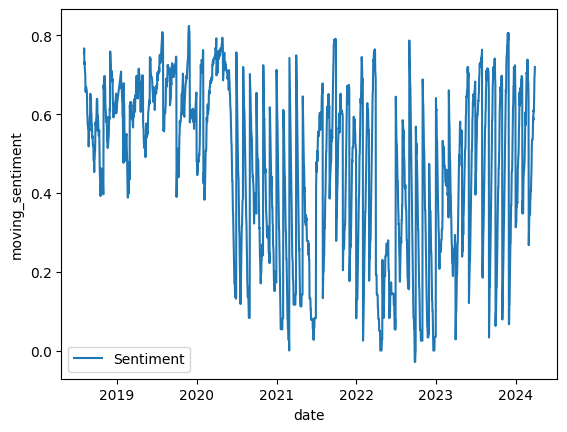

In [32]:
import seaborn as sns


sns.lineplot(data=aggregated_data, x='date', y='moving_sentiment', label='Sentiment')

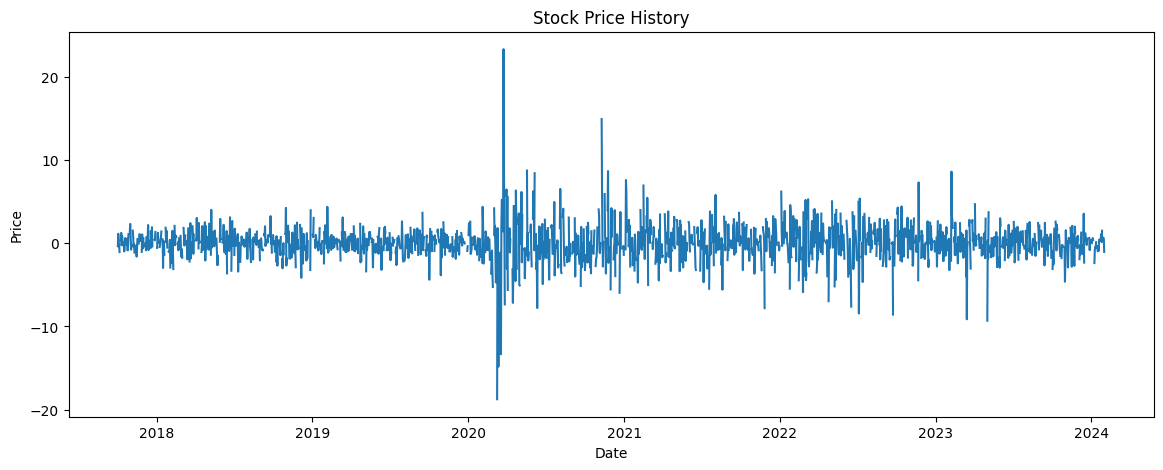

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable


df_stocks = pd.read_pickle('./../data/stocks_daily_data.pkl')
df_bp = df_stocks[['BP/ LN Equity']]

plt.figure(figsize=(14, 5))
plt.plot(df_bp['BP/ LN Equity'])
plt.title('Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [35]:
df_bp_not_na = df_bp[df_bp['BP/ LN Equity'].notna()]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_bp_not_na)
scaled_data

array([[0.43729136],
       [0.47276173],
       [0.44691688],
       ...,
       [0.46105837],
       [0.46003112],
       [0.42076878]])

In [48]:
# Prepare the dataset for the LSTM model
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Setting the time step to 20 days
time_step = 20
X, Y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import math


# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_bp_not_na)

# Prepare the dataset for the LSTM model
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Setting the time step to 20 days
time_step = 20
X, Y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=1)

# Predicting the stock prices
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate RMSE performance metrics
train_rmse = math.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(Y_test, test_predict))

print('Train RMSE: ', train_rmse)
print('Test RMSE: ', test_rmse)

# Plot the results
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict[:len(scaled_data) - len(train_predict) - time_step - 1]

plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Stock Price')
plt.plot(train_predict_plot, label='Train Prediction')
plt.plot(test_predict_plot, label='Test Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.legend()
plt.show()


/Users/jags/Documents/GitHub/overperforming-58-energy-stocks/.env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1262/1262 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0064
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train RMSE:  0.6088317406675912
Test RMSE:  0.5869189356059032


ValueError: could not broadcast input array from shape (316,1) into shape (295,1)

# Look for correlations with volumes

In [102]:
import pandas as pd


df_volumes = pd.read_excel('./../data/actions-energie.xlsx', sheet_name='Bloom')
df_volumes = df_volumes.iloc[:, 2:].T.iloc[:, 3:].reset_index(drop=True).drop(1).reset_index(drop=True)
# df_volumes.to_pickle('./../data/df_volumes.pkl')
df_volumes.columns = df_volumes.iloc[0]
df_volumes = df_volumes.drop(0).reset_index(drop=True)
df_volumes = df_volumes.iloc[:, 2:]
df_volumes['DATE'] = df_volumes.iloc[:, 0].values
df_volumes = df_volumes.iloc[:, 1:]
df_volumes.to_pickle('./../data/df_volumes.pkl')
df_volumes.head()

,BP/ LN Equity,STERV FH Equity,IP US Equity,UPM FH Equity,NEM US Equity,XOM US Equity,VLO US Equity,NUE US Equity,ABX CT Equity,FMC US Equity,...,WMB US Equity,CTRA US Equity,APA US Equity,EOG US Equity,KMI US Equity,EQT US Equity,HAL US Equity,FANG US Equity,S5ENRS Index,DATE
0,5.919372,10.90907,0.791975,11.03876,-3.59904,1.671139,2.547771,3.194147,-10.14396,3.974919,...,-5.031656,3.551402,-9.12874,3.413359,-4.926647,-4.138565,-7.147512,9.391588,-0.662957,2017-10-31
1,-0.988737,-2.246577,-0.288225,0.068212,2.295354,0.855728,9.456333,-0.570638,-4.224525,1.658411,...,1.929825,4.700338,1.111917,2.453189,-4.859194,-4.657615,-2.24614,2.006346,1.762193,2017-11-30
2,6.988426,3.931891,2.349408,3.580244,1.644609,0.420218,7.346415,11.22698,5.066067,0.449586,...,6.062945,-1.208981,0.932345,5.463253,4.875217,-4.496644,17.45519,15.49721,4.883477,2017-12-31
3,0.546154,7.955951,8.491543,8.171395,7.969083,4.375897,4.417365,5.316137,-1.036262,-3.517853,...,2.951787,-7.672212,6.85361,6.727716,0.184205,-4.62052,9.883364,-0.594059,3.81178,2018-01-31
4,-6.449286,3.713166,-4.425673,2.290289,-5.702296,-12.36014,-4.934638,-2.329749,-19.47323,-14.06986,...,-11.56419,-8.311195,-23.89124,-11.8087,-9.899889,-7.272312,-13.5568,-0.685259,-10.81908,2018-02-28


In [1]:
import pandas as pd


df_tweets = pd.read_csv('./../data/webscrapped/predicted/twitter/concatenated_prediction.csv')
df_tweets.drop(columns="Unnamed: 0", inplace=True)
df_tweets['positive_sentiment'] = df_tweets['sentiment'].apply(lambda x: 1 if x == 'Bullish' else 0) + df_tweets['sentiment_base'].apply(lambda x: 1 if x == 'positive' else 0)
df_tweets['negative_sentiment'] = df_tweets['sentiment'].apply(lambda x: 1 if x == 'Bearish' else 0) + df_tweets['sentiment_base'].apply(lambda x: 1 if x == 'negative' else 0)
df_tweets['neutral_sentiment'] = df_tweets['sentiment_base'].apply(lambda x: 1 if x == 'neutral' else 0)
df_tweets['PostDate'] = pd.to_datetime(df_tweets['PostDate'])
df_tweets.to_pickle('./../data/webscrapped/predicted/twitter/cleaned_prediction.pkl')
df_tweets.head()

,User,Handle,PostDate,TweetText,ReplyCount,RetweetCount,LikeCount,sentiment,sentiment_base,company,positive_sentiment,negative_sentiment,neutral_sentiment
0,Peter van Dijk,petrusvandijk,2024-03-30 07:25:49+00:00,9hcountries that want suspend eu deforestation...,0.0,0.0,0,Bullish,neutral,STORA ENSO,1,0,1
1,Jussi Keskin,JussiKeski13219,2024-03-28 22:32:30+00:00,mar 28replying to totuus54 and paulivahtera,0.0,1.0,2,Bullish,neutral,STORA ENSO,1,0,1
2,EuropaWire,europawire,2024-03-28 16:44:18+00:00,mar 28 storaenso releases 2023 greenfinancing ...,0.0,0.0,0,Bearish,neutral,STORA ENSO,0,1,1
3,Travis Perkins Group News,TP_plc,2024-03-28 16:17:04+00:00,mar 28earlier this week the constructionclc pu...,0.0,0.0,0,Bullish,neutral,STORA ENSO,1,0,1
4,Its rider’s name was Death...,TomKeepIt,2024-03-28 14:25:19+00:00,mar 28replying to tomkeepit,0.0,0.0,1,Bullish,neutral,STORA ENSO,1,0,1


#### cumulated performances in base 100

In [1]:
from model.parameters import company_to_stock_dict


list(company_to_stock_dict.values())

# returns[]

['BP/ LN Equity',
 'FMC US Equity',
 'WY US Equity',
 'ALA CT Equity',
 'BHP US Equity',
 'IP US Equity',
 'S5ENRS Equity',
 'STERV FH Equity',
 'WIL SP Equity',
 'TTE FP Equity']

(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300'),
  Text(0, 350.0, '350')])

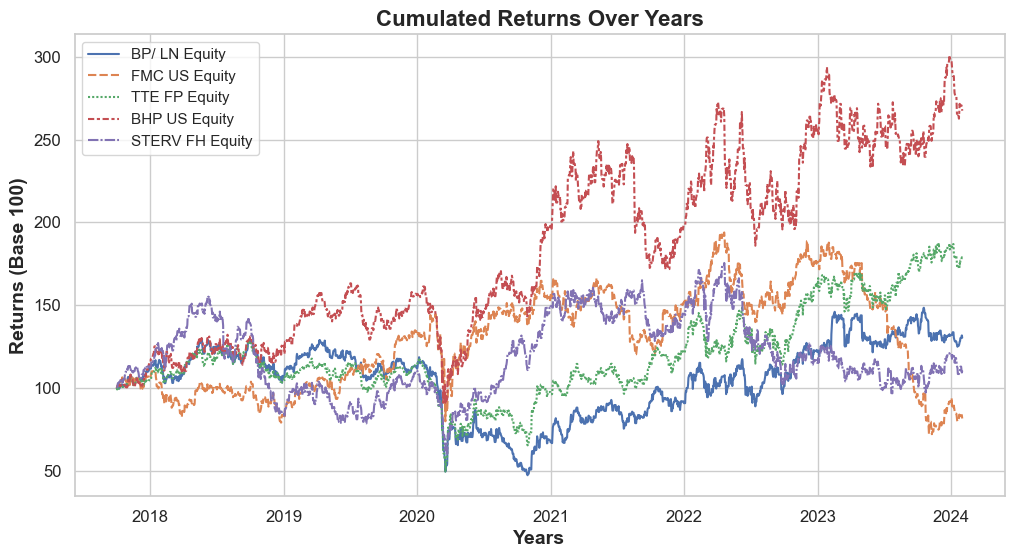

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


returns = pd.read_pickle('./../data/stocks_daily_data.pkl')
returns = returns.fillna(0)
returns = (1 + returns / 100).cumprod() * 100 
returns = returns[['BP/ LN Equity', 'FMC US Equity', 'TTE FP Equity', 'BHP US Equity', 'STERV FH Equity']]

plt.figure(figsize=(12, 6))
sns.lineplot(data=returns, color='b')

# Adding title and labels
plt.title('Cumulated Returns Over Years', fontsize=16, weight='bold')
plt.xlabel('Years', fontsize=14, weight='bold')
plt.ylabel('Returns (Base 100)', fontsize=14, weight='bold')

# Customizing ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


#### mean, std about stocks

In [26]:
import pandas as pd


returns = pd.read_pickle('./../data/stocks_daily_data.pkl')
# returns = returns.fillna(0)
# returns = (1 + returns / 100).cumprod() * 100 
returns = returns[['BP/ LN Equity', 'FMC US Equity', 'TTE FP Equity', 'BHP US Equity', 'STERV FH Equity']]
returns.std()

BP/ LN Equity      2.236191
FMC US Equity      2.108607
TTE FP Equity      1.938879
BHP US Equity      2.090636
STERV FH Equity    2.168932
dtype: float64

#### number of average tweets per day

In [1]:
import pandas as pd


WEBSCRAPPED_DATA_PATH = (
        "./../data/webscrapped/predicted/twitter/concatenated_prediction.csv"
    )
analysed_tweets = pd.read_csv(WEBSCRAPPED_DATA_PATH)

In [2]:
analysed_tweets['PostDate'] = pd.to_datetime(analysed_tweets['PostDate']).dt.date

In [3]:
import datetime


analysed_tweets = analysed_tweets[analysed_tweets['PostDate'] >= datetime.date(2017, 9, 30)]

In [4]:
grouped = analysed_tweets.groupby(['company', 'PostDate'], as_index=False).size()

In [5]:
# Sort DataFrame by company and PostDate
grouped = grouped.sort_values(by=['company', 'PostDate'])

# Calculate cumulative sum of size for each company
grouped['cumsum_size'] = grouped.groupby('company')['size'].cumsum()

grouped

,company,PostDate,size,cumsum_size
0,BHP GROUP,2017-10-01,1,1
1,BHP GROUP,2017-10-02,15,16
2,BHP GROUP,2017-10-03,17,33
3,BHP GROUP,2017-10-04,12,45
4,BHP GROUP,2017-10-05,6,51
...,...,...,...,...
10387,TOTALENERGIES SE,2024-04-26,123,189999
10388,TOTALENERGIES SE,2024-04-27,457,190456
10389,TOTALENERGIES SE,2024-04-28,33,190489
10390,TOTALENERGIES SE,2024-04-29,582,191071


In [6]:
grouped['PostDate'] = pd.to_datetime(grouped['PostDate'])

In [7]:
grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10392 entries, 0 to 10391
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   company      10392 non-null  object        
 1   PostDate     10392 non-null  datetime64[ns]
 2   size         10392 non-null  int64         
 3   cumsum_size  10392 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 324.9+ KB


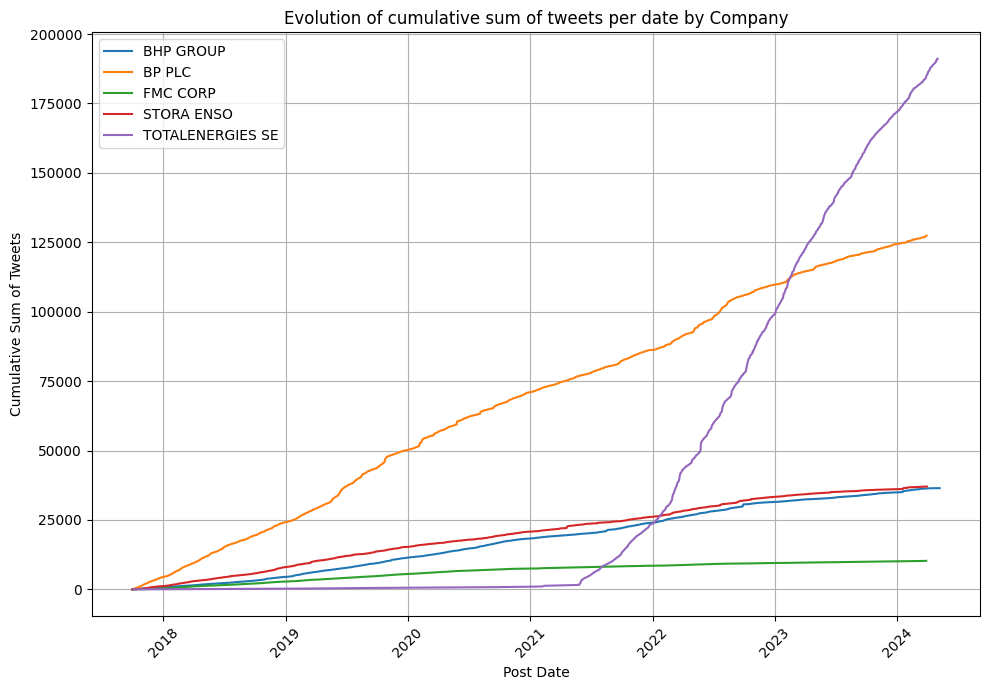

In [8]:
import matplotlib.pyplot as plt


df_grouped = grouped.copy()


plt.figure(figsize=(10, 7))
for company in df_grouped['company'].unique():
    company_data = df_grouped[df_grouped['company'] == company]
    plt.plot(company_data['PostDate'], company_data['cumsum_size'], label=company)

plt.title('Evolution of cumulative sum of tweets per date by Company')
plt.xlabel('Post Date')
plt.ylabel('Cumulative Sum of Tweets')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [9]:
# import seaborn as sns 


# sns.barplot(data=grouped, x="PostDate", y='cumsum_size', hue='company')

In [10]:
grouped['quarter-year'] = grouped['PostDate'].dt.to_period('Q')
quarterly_grouped = grouped.groupby(['company', 'quarter-year'], as_index=False)['size'].sum()
quarterly_grouped

,company,quarter-year,size
0,BHP GROUP,2017Q4,797
1,BHP GROUP,2018Q1,636
2,BHP GROUP,2018Q2,830
3,BHP GROUP,2018Q3,898
4,BHP GROUP,2018Q4,1339
...,...,...,...
130,TOTALENERGIES SE,2023Q2,18980
131,TOTALENERGIES SE,2023Q3,17359
132,TOTALENERGIES SE,2023Q4,13098
133,TOTALENERGIES SE,2024Q1,13540


In [11]:
monthly_grouped_bhp = quarterly_grouped[quarterly_grouped['company']=='BHP GROUP']
monthly_grouped_bp = quarterly_grouped[quarterly_grouped['company']=='BP PLC']
monthly_grouped_fmc = quarterly_grouped[quarterly_grouped['company']=='FMC CORP']
monthly_grouped_stora = quarterly_grouped[quarterly_grouped['company']=='STORA ENSO']
monthly_grouped_total = quarterly_grouped[quarterly_grouped['company']=='TOTALENERGIES SE']

Text(0.5, 1.0, 'Average number of tweets by quarter')

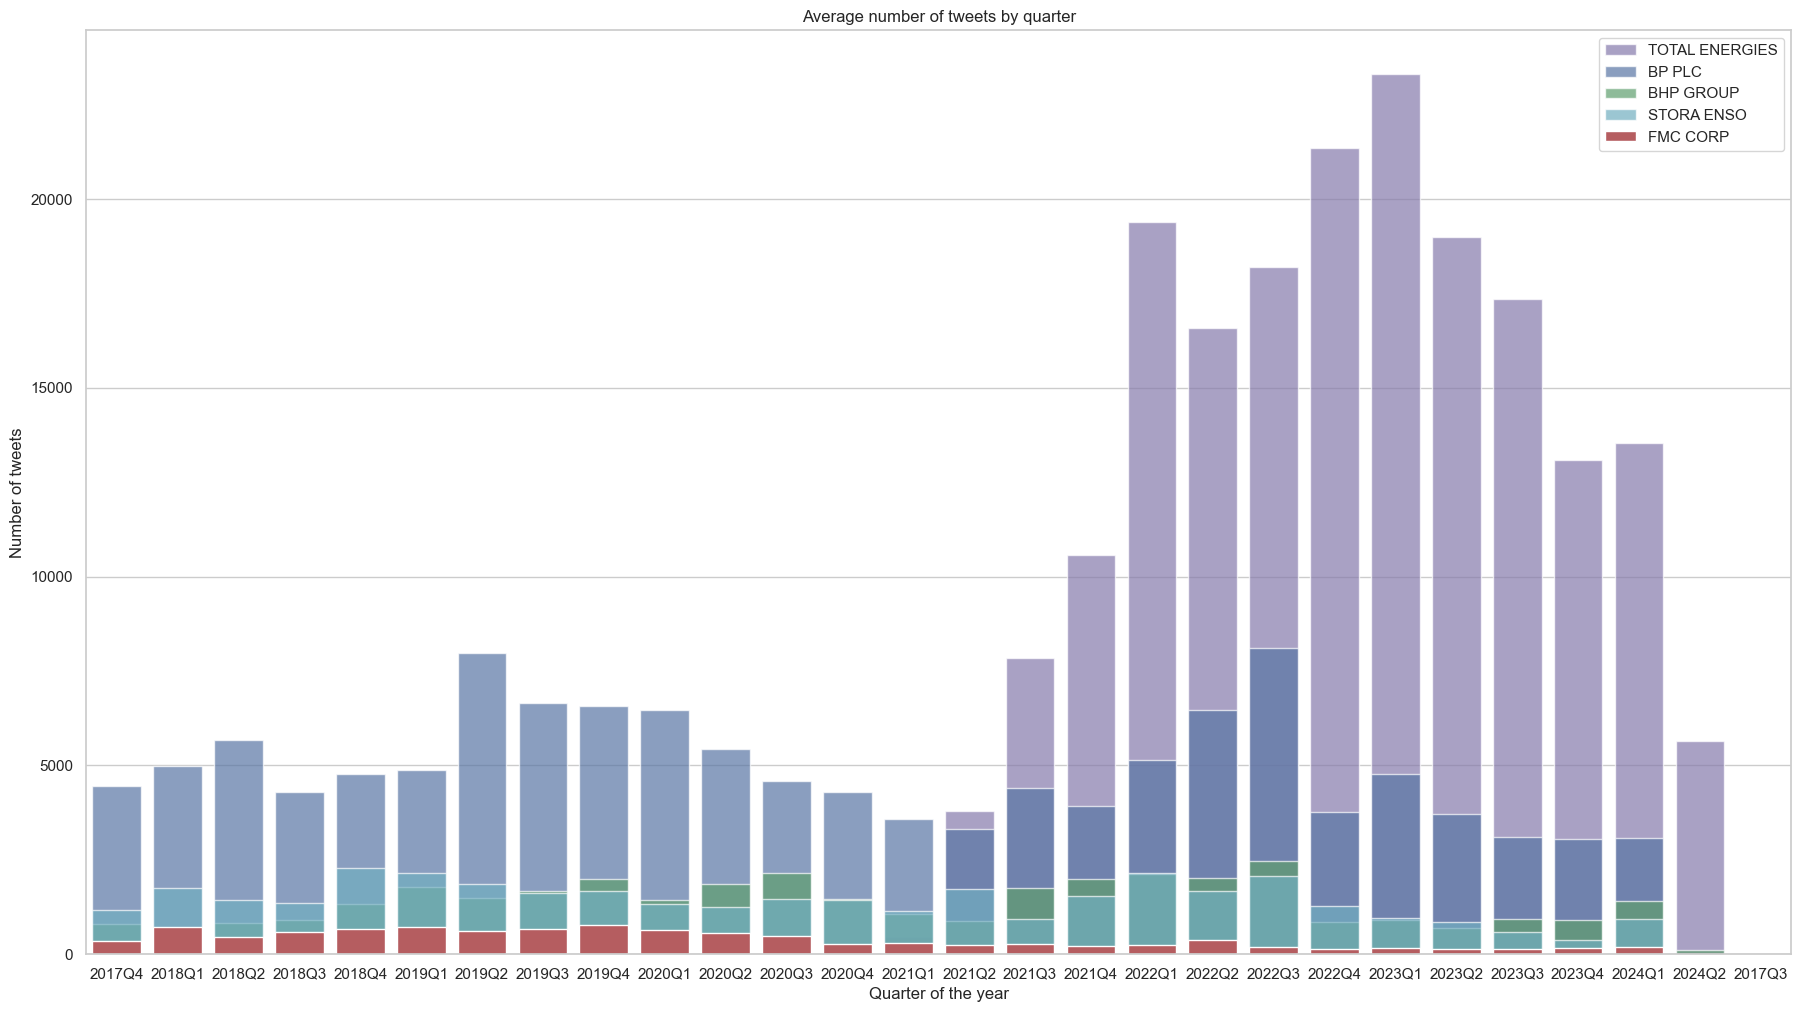

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

plt.figure(figsize=(22, 12))

colors = ['b', 'g', 'r', 'c', 'm']

# Plot the total crashes
sns.barplot(x="quarter-year", y="size", color=colors[4], alpha=0.7, data=monthly_grouped_total, label='TOTAL ENERGIES')

sns.barplot(x="quarter-year", y="size", color=colors[0], alpha=0.7, data=monthly_grouped_bp, label='BP PLC')

sns.barplot(x="quarter-year", y="size", color=colors[1], alpha=0.7, data=monthly_grouped_bhp, label='BHP GROUP')

sns.barplot(x="quarter-year", y="size", color=colors[3], alpha=0.7, data=monthly_grouped_stora, label='STORA ENSO')

sns.barplot(x="quarter-year", y="size", color=colors[2], alpha=1, data=monthly_grouped_fmc, label='FMC CORP')

plt.ylabel("Number of tweets")
plt.xlabel("Quarter of the year")
plt.title("Average number of tweets by quarter")


In [17]:
quarter_year = quarterly_grouped['quarter-year'].unique().tolist()
companies = quarterly_grouped['company'].unique().tolist()

for company in companies:
    company_df = quarterly_grouped[(quarterly_grouped['company']==company)]
    for quarter in quarter_year:
        print(company_df[company_df['quarter-year']==quarter].shape)
        if company_df[company_df['quarter-year']==quarter].shape[0] == 0:
            print(company, quarter)

(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(0, 3)
BHP GROUP 2017Q3
(1, 3)
(0, 3)
BHP GROUP 2024Q2
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(0, 3)
BP PLC 2024Q2
(1, 3)
(0, 3)
BP PLC 2017Q3
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(0, 3)
FMC CORP 2024Q2
(1, 3)
(0, 3)
FMC CORP 2017Q3
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(0, 3)
STORA ENSO 2024Q2
(1, 3)
(0, 3)
STORA ENSO 2017Q3
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1

In [18]:
quarterly_grouped[quarterly_grouped['company']=='BHP GROUP']

,company,quarter-year,size
0,BHP GROUP,2017Q4,797
1,BHP GROUP,2018Q1,636
2,BHP GROUP,2018Q2,830
3,BHP GROUP,2018Q3,898
4,BHP GROUP,2018Q4,1339
5,BHP GROUP,2019Q1,1767
6,BHP GROUP,2019Q2,1487
7,BHP GROUP,2019Q3,1680
8,BHP GROUP,2019Q4,1990
9,BHP GROUP,2020Q1,1424


In [15]:
# New data to add
new_rows = pd.DataFrame({
    'company': ['BHP GROUP', 'BP PLC', 'FMC CORP', 'STORA ENSO', 'TOTALENERGIES SE'],
    'size': [0, 0, 0, 0, 0],
    'quarter-year': ['2017Q3', '2024Q2', '2024Q2', '2024Q2', '2017Q3']
})

# Add the new rows
quarterly_grouped = pd.concat([quarterly_grouped, new_rows], ignore_index=True)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (28,) and arg 3 with shape (30,).

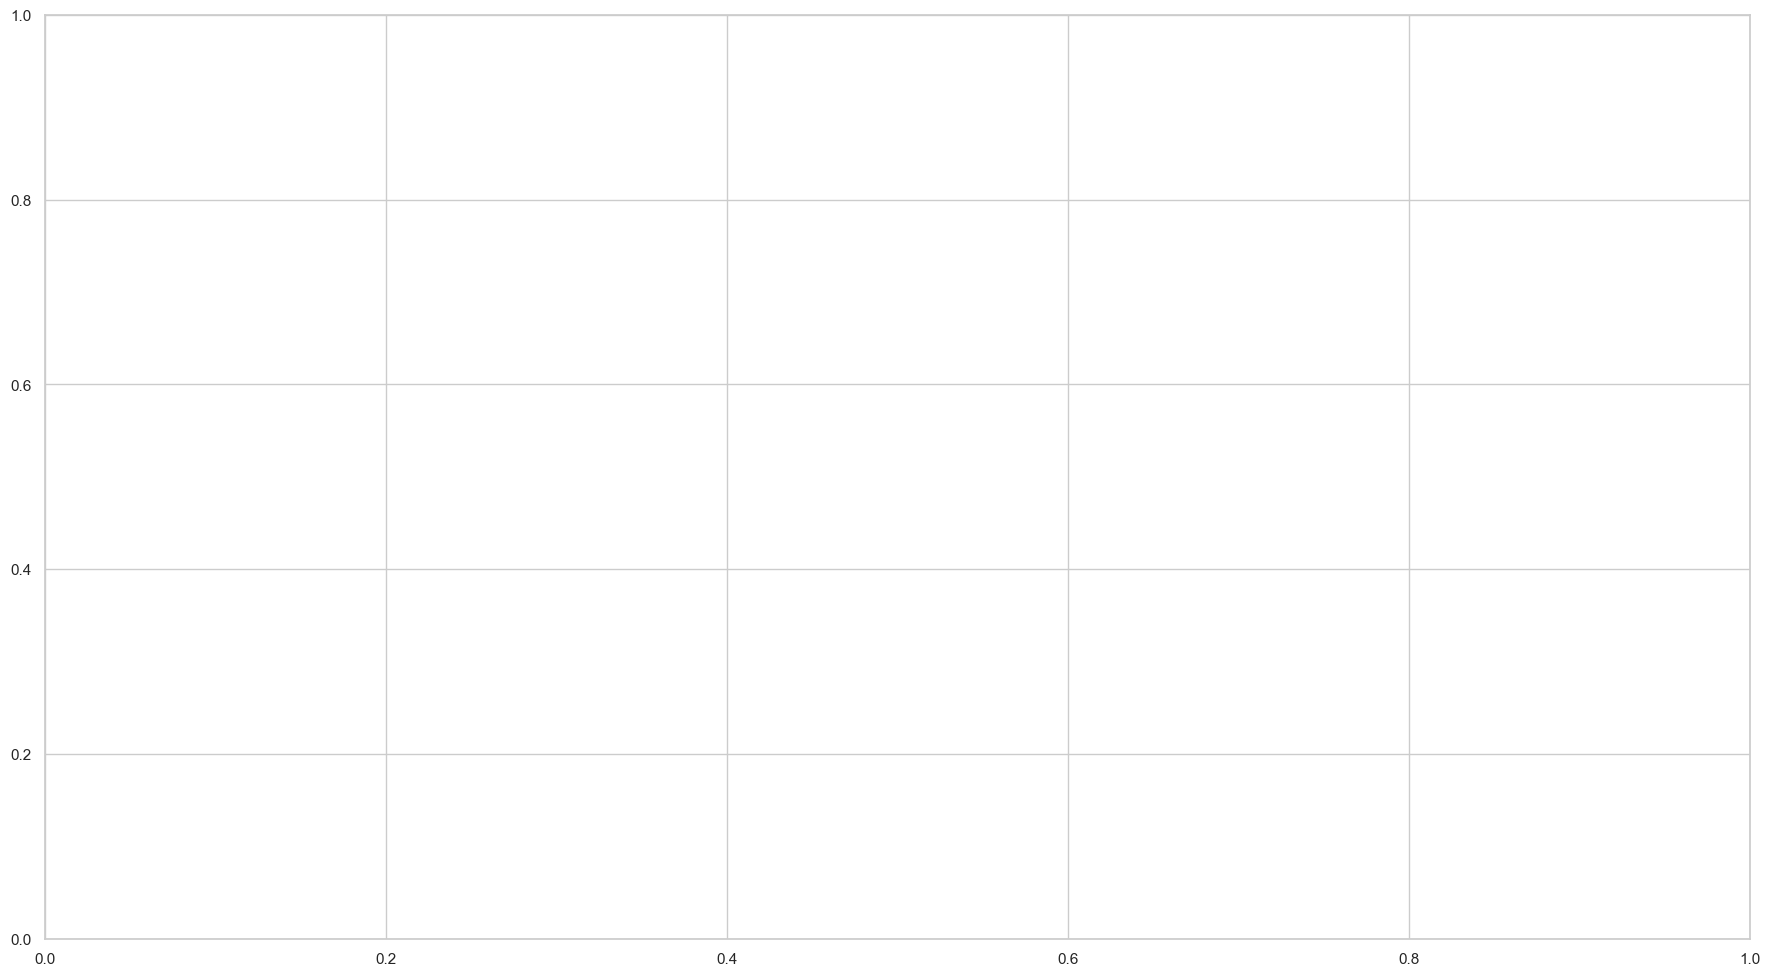

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame
data = {
    'quarter-year': ['Q1-2022', 'Q2-2022', 'Q3-2022', 'Q4-2022'],
    'TOTAL ENERGIES': [10, 15, 20, 25],
    'BP PLC': [5, 10, 15, 20],
    'BHP GROUP': [2, 5, 8, 12],
    'STORA ENSO': [1, 3, 5, 7],
    'FMC CORP': [0, 2, 4, 6]
}


df = pd.DataFrame(data)
df.set_index('quarter-year', inplace=True)

# Plot
plt.figure(figsize=(22, 12))

companies = quarterly_grouped['company'].unique()
bottoms = [0] * len(quarterly_grouped['quarter-year'].unique().tolist())

for company in companies:
    plt.bar(quarterly_grouped[quarterly_grouped['company']==company]['quarter-year'], quarterly_grouped[quarterly_grouped['company']==company]['size'], bottom=bottoms, label=company)
    bottoms = [i + j for i, j in zip(bottoms, quarterly_grouped[quarterly_grouped['company']==company]['quarter-year'])]

plt.xlabel('Quarter-Year')
plt.ylabel('Size')
plt.title('Stacked Bar Plot of Crashes by Company')
plt.legend(title='Company')
plt.grid(axis='y')
plt.xticks(rotation=45)  # Rotate x labels if needed

plt.tight_layout()
plt.show()
